In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Some Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [7]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [8]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [9]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [10]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [11]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Fitting DeLASE

In [44]:
delase_wake = DeLASE(wake_signal[:15000], matrix_size=6400, dt=dt, use_torch=True, device='cuda')
delase_wake.compute_havok_dmd(r=500, lamb=0)
delase_wake.compute_jacobians()
delase_wake.get_stability()

In [45]:
delase_anesthesia = DeLASE(anesthesia_signal[:15000], matrix_size=6400, dt=dt, use_torch=True, device='cuda')
delase_anesthesia.compute_havok_dmd(r=500, lamb=0)
delase_anesthesia.compute_jacobians()
delase_anesthesia.get_stability()

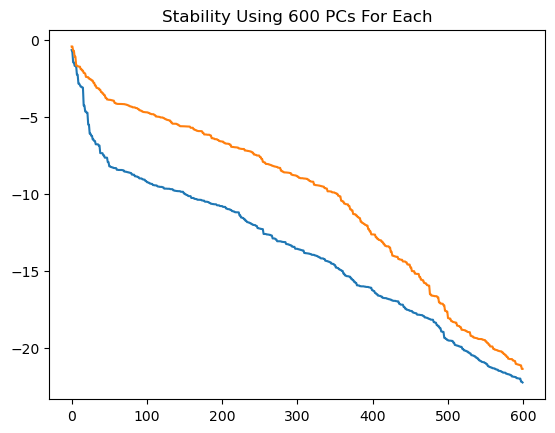

In [48]:
plt.plot(delase_wake.stability_params[:600].cpu())
plt.plot(delase_anesthesia.stability_params[:600].cpu())
plt.title('Stability Using 600 PCs For Each')
plt.show()

In [17]:
delase_wake.r

215

In [18]:
delase_anesthesia.r

3

In [23]:
def compute_cumulative_explained(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

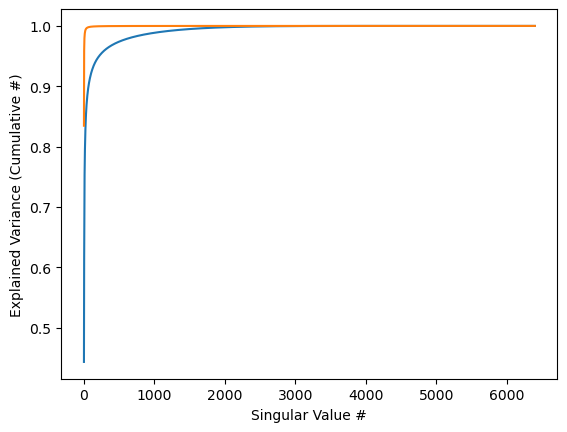

In [47]:
plt.plot(compute_cumulative_explained(delase_wake.S.cpu()))
plt.plot(compute_cumulative_explained(delase_anesthesia.S.cpu()))
plt.xlabel('Singular Value #')
plt.ylabel('Explained Variance (Cumulative #)')
# plt.ylim([0.999, 1.0001])
plt.show()

In [33]:
torch.sum(delase_anesthesia.S > 0.3)

tensor(3720, device='cuda:0')

In [42]:
preds = delase_anesthesia.predict_havok_dmd(anesthesia_signal[15000:], reseed=500, tail_bite=True, use_real_coords=True)

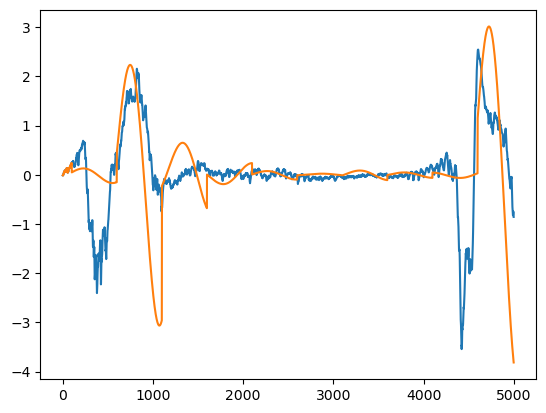

In [43]:
plt.plot(anesthesia_signal[15000:, 0])
plt.plot(preds[:, 0].cpu())